# Programming assignment #6

## 1 Model performance

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_curve, auc, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier, plot_tree

import imblearn
from imblearn.over_sampling import RandomOverSampler 

### 1.1 Dataset size vs model performance

In [3]:
#create monthly features
kaggle = pd.read_csv('Retail_Data_Response.csv')

mth_rolling_features = pd.read_excel('mth_rolling_features.xlsx')
mth_rolling_features = mth_rolling_features.drop('Unnamed: 0', axis = 1)
mth_rolling_features = mth_rolling_features.fillna(0)

mth_day_counts = pd.read_excel('mth_day_counts.xlsx')
mth_day_counts = mth_day_counts.drop('Unnamed: 0', axis = 1)

day_since_last_txn = pd.read_excel('days_since_last_txn.xlsx')
day_since_last_txn = day_since_last_txn.drop('Unnamed: 0', axis = 1)

mth_features_outputs = pd.merge(mth_rolling_features, mth_day_counts, on = ['CLNT_NO', 'ME_DT']).merge(day_since_last_txn, on = ['CLNT_NO', 'ME_DT']).merge(kaggle.rename(columns={'customer_id': 'CLNT_NO'}), on = 'CLNT_NO')
mth_features_outputs.head() 

,CLNT_NO,ME_DT,mth_txn_amt_sum,mth_txn_cnt,amt_sum_3M,amt_mean_3M,amt_max_3M,txn_cnt_sum_3M,txn_cnt_mean_3M,txn_cnt_max_3M,amt_sum_6M,amt_mean_6M,amt_max_6M,txn_cnt_sum_6M,txn_cnt_mean_6M,txn_cnt_max_6M,amt_sum_12M,amt_mean_12M,amt_max_12M,txn_cnt_sum_12M,txn_cnt_mean_12M,txn_cnt_max_12M,cnt_Friday,cnt_Monday,cnt_Saturday,cnt_Sunday,cnt_Thursday,cnt_Tuesday,cnt_Wednesday,days_since_last_txn,response
0,CS1112,2011-05-31,0,0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,-5,0
1,CS1112,2011-06-30,56,1,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,1,15,0
2,CS1112,2011-07-31,0,0,56.0,18.666667,56.0,1.0,0.333333,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,46,0
3,CS1112,2011-08-31,96,1,152.0,50.666667,96.0,2.0,0.666667,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,12,0
4,CS1112,2011-09-30,0,0,96.0,32.000000,96.0,1.0,0.333333,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,42,0


> Here, you will quantify the relationship between the dataset size and the model performance. Essentially, you will answer the question: how much data is enough to model client behaviour? In order to do this, you will pick the best single tree model you created in Assignment #5 and evaluate it with datasets of different sizes using the monthly features you created in Assignment #3.
>
> Perform the evaluation with the following steps:
> 1. Split the train/test sets with 9:1 ratio. This split should give you approximately 291k/32k samples in train/test set, respectively.


In [4]:
#drop CLNT_NO, ME_DT and response for X_annual
X_mth = mth_features_outputs.drop(['CLNT_NO', 'response', 'ME_DT'], axis = 1)
y_mth = mth_features_outputs['response']
#Split the data in train and test set.
X_train, X_test, y_train, y_test = train_test_split(X_mth, y_mth, test_size=0.1, random_state=1147)

>2. Initialize and create a for loop in which you take N samples (e.g. 50), build a tree
model with the N samples and evaluate the test set AUC. Repeat the sampling process
10 times and append the test set AUC. The following table shows the desired output:

|N = 50 |samples|
|----|----|
|sample #| Test AUC|
|1| 0.545|
|2| 0.561|
|...|...|
|10| 0.551|
>
> From this table, you can calculate the mean and standard deviation of the test AUC for N samples.

In [43]:
def tree_model_N_samples(N):
    test_auc = []
    
    for num in range(10):
        X_train_samples = X_train.sample(n = N)
        idx = X_train_samples.index
        y_train_samples = y_train[idx]

        dt = DecisionTreeClassifier(max_depth = 5, random_state = 1147, class_weight='balanced')
        dt.fit(X_train_samples, y_train_samples)

        scores_test  = dt.predict_proba(X_test)[:,1]
        fpr_test, tpr_test, _ = roc_curve(y_test, scores_test)
        test_auc.append(auc(fpr_test, tpr_test))

        # calculate the mean and standard deviation of the test AUC for N samples
        test_auc_mean = np.mean(test_auc)
        test_auc_std = np.std(test_auc)
    return test_auc, test_auc_mean, test_auc_std

In [52]:
test_auc, test_auc_mean, test_auc_std = tree_model_N_samples(50)
test_auc_table = {'sample': np.arange(1,11),'Test AUC': test_auc}
pd.DataFrame(test_auc_table).style.hide_index()

sample,Test AUC
1,0.505882
2,0.522168
3,0.504770
4,0.495398
5,0.502618
6,0.512942
7,0.505607
8,0.498598
9,0.508994
10,0.483356


In [53]:
# calculate the mean and standard deviation of the test AUC for N samples
print ('mean of the test AUC for 50 samples:', test_auc_mean)
print ('standard deviation of the test AUC for 50 samples:', test_auc_std)

mean of the test AUC for 50 samples: 0.5040333731445146
standard deviation of the test AUC for 50 samples: 0.009863621380747475


> 3. Repeat the procedure you performed in the previous step for different sample size N
(e.g. 100, 500, 1000, 2000, 5000, 10000).

In [55]:
N = [100, 500, 1000, 2000, 5000, 10000, 20000]
mean_list = []
std_list = []
for n in N:
  test_auc, test_auc_mean, test_auc_std = tree_model_N_samples(n)
  mean_list.append(test_auc_mean)
  std_list.append(test_auc_std)

> 4. Build a table that contains the values of:
> * Sample size N
> * Test AUC mean
> * Test AUC standard deviation

In [56]:
N_samples_Auc_table = {'Sample size N': N, 'Test AUC mean': mean_list, 'Test AUC standard deviation': std_list}
pd.DataFrame(N_samples_Auc_table).style.hide_index()

Sample size N,Test AUC mean,Test AUC standard deviation
100,0.510304,0.025084
500,0.537842,0.025630
1000,0.549496,0.026432
2000,0.569502,0.013424
5000,0.595380,0.007208
10000,0.611988,0.005331
20000,0.625050,0.004800


> 5. Using the matplotlib function errorbar, plot the model performance captured in the
test AUC mean and standard deviation as a function of the sample size. From this
plot, can you estimate what is the minimum number of samples needed to model the
behaviour adequately?

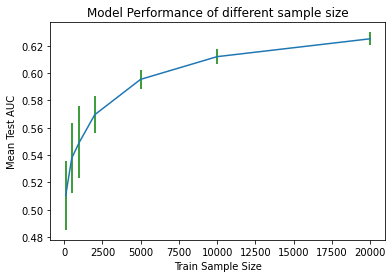

In [59]:
plt.errorbar(N, mean_list, yerr=std_list, ecolor = 'g') 
plt.title('Model Performance of different sample size')
plt.ylabel('Mean Test AUC')
plt.xlabel('Train Sample Size')
plt.show()

From the graph above, it clearly shows that the mean of test AUC scores are increasing and the standard deviations are decreasing. The inflection point of the mean of test AUC scores is 10000, and after 10000, the standard deviation almost stays the same. Therefore, the minimum sample size for this decision tree model to behave well is 10000.